In [ ]:
# import torch
# import hmmscan_utils as hu
# import ml_utils as ml
# import pickle
# from pathlib import Path
# from Bio import SeqIO
# from esm import FastaBatchedDataset, pretrained
# from torch import nn
# from tqdm import tqdm
# import numpy as np

In [ ]:
import numpy as np
from pathlib import Path
import os, sys
from tqdm import tqdm
import wandb

import torch
from torch import nn

sys.path.insert(0, '../library')
import hmmscan_utils as hu
import ml_utils as mu

Load ESM2 Model

In [ ]:
import torch
import torch.nn.functional as F

# Initialize a random tensor of size 19633
x = torch.randn(19633)*1000

# Initialize a target tensor of the same size
y = torch.zeros(19633)
y[1]=1

# Compute the L1 loss
loss = F.l1_loss(x, y)

print(loss)

In [ ]:
import pickle
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [ ]:
import hmmscan_utils as hu
import ml_utils as mu
import classifiers as c
import torch
from esm import pretrained
from pathlib import Path
import pickle

hmm_data = hu.parse_hmmscan_results("../data/split_1_train_ids_full.fasta_scan.txt")

# Load esm2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'esm2_t33_650M_UR50D'
model, alphabet = pretrained.load_model_and_alphabet(model_name)
model.eval()
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
last_layer = model.num_layers
embed_dim = model.embed_dim

# Load model
classifier = c.TryLSTM(embed_dim, 657).to(device)
# classifier = mu.ContextWeightedSum(embed_dim, 657).to(device)
state_dict = torch.load("../data/results/try_lstm_run1/epoch_4.pth")
# state_dict = torch.load("../data/results/context_weighted_run1/epoch_2.pth")

classifier.load_state_dict(state_dict)

# Load maps and generate idx_to_clan map
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
        maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}
idx_to_fam = {v: k for k,v in maps["fam_idx"].items()}

# Run esm2
batch_converter = alphabet.get_batch_converter()
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("Q59325","MKFRRSICTAVLLAVLLTLLVPTSVFALEDNSSTLPPYKNDLLYERTFDEGLCYPWHTCEDSGGKCSFDVVDVPGQPGNKAFAVTVLDKGQNRWSVQMRHRGLTLEQGHTYRVRLKIWADASCKVYIKIGQMGEPYAEYWNNKWSPYTLTAGKVLEIDETFVMDKPTDDTCEFTFHLGGELAATPPYTVYLDDVSLYDPEYTKPVEYILPQPDVRVNQVGYLPEGKKVATVVCNSTQPVKWQLKNAAGVVVLEGYTEPKGLDKDSQDYVHWLDFSDFATEGIGYYFELPTVNSPTNYSHPFDIRKDIYTQMKYDALAFFYHKRSGIPIEMPYAGGEQWTRPAGHIGIEPNKGDTNVPTWPQDDEYAGIPQKNYTKDVTGGWYDAGDHGKYVVNGGIAVWTLMNMYERAKIRGLDNWGPYRDGGMNIPEQNNGYPDILDEARWEIEFFKKMQVTEKEDPSIAGMVHHKIHDFRWTALGMLPHEDPQPRYLRPVSTAATLNFAATLAQSARLWKDYDPTFAADCLEKAEIAWQAALKHPDIYAEYTPGSGGPGGGPYNDDYVGDEFYWAACELYVTTGKDEYKNYLMNSPHYLEMPAKMGENGGANGEDNGLWGCFTWGTTQGLGTITLALVENGLPATDIQKARNNIAKAADRWLENIEEQGYRLPIKQAEDERGGYPWGSNSFILNQMIVMGYAYDFTGDSKYLDGMFDGISYLLGRNAMDQSYVTGYGERPLQNPHDRFWTPQTSKRFPAPPPGIISGGPNSRFEDPTINAAVKKDTPPQKCFIDHTDSWSTNEITVNWNAPFAWVTAYLDEQYTDSETDKVTIDSPVAGERFEAGKDINISATVKSKTPVSKVEFYNGDTLISSDTTAPYTAKITGAAVGAYNLKAVAVLSDGRRIESPVTPVLVKVIVKPTVKLTAPKSNVVAYGNEFLKITATASDSDGKISRVDFLVDGEVIGSDREAPYEYEWKAVEGNHEISVIAYDDDDAASTPDSVKIFVKQARDVKVQYLCENTQTSTQEIKGKFNIVNTGNRDYSLKDIVLRYYFTKEHNSQLQFICYYTPIGSGNLIPSFGGSGDEHYLQLEFKDVKLPAGGQTGEIQFVIRYADNSFHDQSNDYSFDPTIKAFQDYGKVTLYKNGELVWGTPPGGTEPEEPEEPEEPEEPAIVYGDCNDDGKVNSTDVAVMKRYLKKENVNINLDNADVNADGKVNSTDFSILKRYVMKNIEELPYR")
    ]
# data = [("rdrp","MDVDTAFLNSTMDEPIYVKQPPGFVNERNPDYVWELYGGMYGLKQAPLLWNEHINNTLKKIGFCRHEGEHGLYFRSTSDGPIYIAVYVDDLLVAAPSPKIYDRVKQELTKLYSMKDLGKVDKFLGLNIHQSSNGDITLSLQDYIAKAASESEINTFKLTQTPLCNSKPLFETTSPHLKDITPYQSIVGQLLFCANTGRPDISYPVSLLSRFLREPRAIHLESARRVLRYLYTTRSMCLKYRSGSQLALTVYCDASHGAIHDLPHSTGGYVTLLAGAPVTWSSKKLKGVIPVPSTEAEYITASETVMEI")]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)


results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

# Get preds
emb = token_representations[0,1:-1,:]
clan_preds = classifier(emb)
clan_preds = torch.nn.functional.softmax(clan_preds,dim=1)
# fam_preds = torch.nn.functional.softmax(fam_preds,dim=1)

# Get top k clans and their values
def top5_argmaxes_with_values(input_tensor, mapping,k):
    # Use torch.topk to find the top 5 values and their indices along dimension 1
    top5_values, top5_indices = torch.topk(input_tensor, k, dim=1)

    # Convert the indices tensor to a list of lists
    indices_list = top5_indices.tolist()

    # Convert the values tensor to a list of lists
    values_list = top5_values.tolist()

    # Apply the mapping to each index and pair it with the corresponding value
    mapped_list = [[(mapping[index], value) for index, value in zip(indices, values)] for indices, values in zip(indices_list, values_list)]

    # Sort the tuples in each list by value in descending order
    sorted_list = [sorted(sublist, key=lambda x: x[1], reverse=True) for sublist in mapped_list]

    return sorted_list



In [ ]:
mapped_list = top5_argmaxes_with_values(clan_preds, idx_to_clan,2)

In [ ]:
mapped_list[1000:]

In [ ]:
with open(Path('../data_esm_decoder') / 'maps.pkl', 'wb') as f:
        pickle.dump(maps,f)

In [ ]:
maps.keys()

In [ ]:
maps["clan_count"] = len(maps["clan_idx"])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'esm2_t33_650M_UR50D'
model, alphabet = pretrained.load_model_and_alphabet(model_name)
model.eval()
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
last_layer = model.num_layers
embed_dim = model.embed_dim

In [ ]:

classifier = mu.LinearHead3(embed_dim, 2*embed_dim, 657).to(device)
state_dict = torch.load("../data/results/linear_3_run4/epoch_0.pth")
classifier.load_state_dict(state_dict)

In [ ]:
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
        maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}

In [ ]:
batch_converter = alphabet.get_batch_converter()
# Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
data = [
    ("test", "MTTSAYTRRTALMTVGMAAATALTGCASTLVPATTQTIEEGAASSSSSERTDFSGEAKIENYDTSAGTYEPATREHRAKNVPKPILPEEANKNSVAGLHANIAYLAAAYIYGFNSGDAECVGKSALSSEDKASLTRAIGRVSGSTWLADPTLIISLKEATPRQDGDTYTWPALLTLKIGPFRVKNRSVEEVPESERSHEFPMDIVARYKDERWVFDTLPNDSSSSPGAGGTSRI")
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)


results = model(batch_tokens.to(device), repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [ ]:
emb = token_representations[0,1:-1,:]
preds = classifier(emb)

In [ ]:
clan_idxs = torch.argmax(preds, dim=1)
clan_idxs_list = clan_idxs.cpu().tolist()

In [ ]:
def top5_argmaxes_with_values(input_tensor, mapping,k):
    # Use torch.topk to find the top 5 values and their indices along dimension 1
    top5_values, top5_indices = torch.topk(input_tensor, k, dim=1)

    # Convert the indices tensor to a list of lists
    indices_list = top5_indices.tolist()

    # Convert the values tensor to a list of lists
    values_list = top5_values.tolist()

    # Apply the mapping to each index and pair it with the corresponding value
    mapped_list = [[(mapping[index], value) for index, value in zip(indices, values)] for indices, values in zip(indices_list, values_list)]

    # Sort the tuples in each list by value in descending order
    sorted_list = [sorted(sublist, key=lambda x: x[1], reverse=True) for sublist in mapped_list]

    return sorted_list

In [ ]:
mapped_list = top5_argmaxes_with_values(preds, idx_to_clan,3)

In [ ]:
mapped_list[67:218]

In [ ]:
clan_names = [idx_to_clan[x] for x in clan_idxs_list]

In [ ]:
clan_names

In [ ]:
hmm_data["P14528.1"]

In [ ]:
_, clan_vector = hu.generate_domain_position_list(hmm_data, "G8QNJ9.1", maps)

In [ ]:
_, clan_vector = hu.generate_domain_position_list(hmm_data, "G8QNJ9.1", maps)
with open(Path('../data_esm_decoder') / 'maps.pkl', 'rb') as f:
    maps = pickle.load(f)
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}
clan_vector_idxs = torch.argmax(torch.tensor(clan_vector).T,dim=1)
clan_vector_idxs_list = clan_vector_idxs.cpu().tolist()
clan_vector_names = [idx_to_clan[x] for x in clan_vector_idxs_list]

In [ ]:
clan_vector.shape

In [ ]:
clan_vector_names[813:]

In [ ]:
maps["clan_idx"]["CL0001"]

In [ ]:
maps["fam_clan"]["PF00008.30"]

In [ ]:
def is_string_in_list(s, lst):
    return any(s in item for item in lst)
is_string_in_list("PF19843",list(maps["fam_clan"].keys()))

In [ ]:
import torch

In [ ]:
input_tensor = torch.ones(19633)*3
input_tensor[1] = 10

# Create a target where the one is at position 1
target = torch.zeros(19633).long()
target[0] = 1

# Compute the cross-entropy loss
loss = torch.nn.functional.cross_entropy(input_tensor.unsqueeze(0), target.argmax().unsqueeze(0))

print(loss)

In [ ]:
logits

In [ ]:
x = torch.randint(0,10,(100,657),dtype=torch.float32)

In [ ]:
 x_reshaped = x.transpose(0, 1).unsqueeze(0)

# Apply 1D average pooling
local_pooled_embed = torch.nn.functional.avg_pool1d(x_reshaped, kernel_size=21, stride=1, padding=10)

#Remove the extra batch dimension and transpose the tensor back to shape (L, d)
local_pooled_embed = local_pooled_embed.squeeze(0).transpose(0, 1)
local_pooled_embed.shape

In [ ]:
pooled = torch.nn.functional.avg_pool1d(x,kernel_size=21,stride=1,padding=10)

In [ ]:
pooled.shape

In [ ]:
x_unsqueezed = x.T.unsqueeze(0)

# Apply 1D average pooling with a kernel size of 21, stride of 1, and padding of 10
pooled = torch.nn.functional.avg_pool1d(x_unsqueezed, kernel_size=21, stride=1, padding=10)

local_pooled_embed = pooled.squeeze(0)

In [ ]:
local_pooled_embed.shape

In [ ]:
x_unsqueezed.shape

In [ ]:
local_pooled_embed[:,:20]

In [ ]:
pooled[:,:10]

In [ ]:
x.shape

In [ ]:
print(x)

In [ ]:
bruh =torch.zeros((3,6))

In [ ]:
bruh

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
length_limit = 4096 # Covers 99.75% sequences
model_name =  'esm2_t33_650M_UR50D' #'esm2_t36_3B_UR50D'
num_shards = 50
data_utils = mu.DataUtils('../data', num_shards, model_name, length_limit, device)

classifier = mu.LinearHead3NormedFam(data_utils.embedding_dim,data_utils.clan_count,data_utils.fam_count,1).to(device)

In [ ]:
# Check the data type of the model parameters
for name, param in classifier.named_parameters():
    print(name, param.dtype)

In [ ]:
a = torch.randint(0,10,(100,20000)).float()
b = torch.randint(1000,2000,(100,20000)).float()

In [ ]:
squared_diff = torch.nn.functional.mse_loss(a,b,reduction="none")

In [ ]:
squared_diff.shape

In [ ]:
squared_diff.dtype

In [ ]:
row_sse = squared_diff.sum(dim=1)

In [ ]:
row_sse.shape

In [ ]:
avg_row_sse = row_sse.mean()

In [ ]:
avg_row_sse.shape

In [ ]:
avg_row_sse.dtype

In [ ]:
avg_row_sse

In [ ]:
row_sse_soft = torch.nn.functional.softmax(row_sse,dim=0)

In [ ]:
row_sse_soft.dtype

In [ ]:
import pickle
import torch

with open('../data/results/try_lstm_run1/predictions_esm2_t33_650M_UR50D/agg_results.pkl', 'rb') as f:
        results = pickle.load(f)

In [ ]:
len(results["clan_wise"][655])

In [ ]:
import numpy as np

In [ ]:
# Assuming `d` is your dictionary
d = results["clan_wise"]

# 1) Get a list of the keys
xs = []

# 2) Create a tensor of length = the largest key + 1

ys = []

# Populate the tensor with the average of the values for each key
for key, values in d.items():
    ys.append(sum(values) / len(values))
    xs.append(key)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
f, ax = plt.subplots(figsize=(20,8))

ax.bar(xs,ys)
ax.set_xlabel('Clan')
ax.set_ylabel('Average accuracy')
ax.set_title(f'Prediction Accuracy Over Each Clan')

ax.grid(False)

In [ ]:
import pandas as pd

In [ ]:
import hmmscan_utils as hu
from tqdm import tqdm

In [ ]:
 with open('../data_esm_decoder/maps.pkl', 'rb') as f:
    maps = pickle.load(f)

In [ ]:
maps.keys()

In [ ]:
idx_to_clan = {v: k for k, v in maps["clan_idx"].items()}

In [ ]:
clan_dict = {i:0 for i in range(657)}
fam_dict = {i:0 for i in range(19633)}

for i in tqdm(range(1,51)):
    scan_shard = f"../data/split_{i}_train_ids_full.fasta_scan.txt"
    hmm_dict = hu.parse_hmmscan_results(scan_shard)
    for seq in hmm_dict:
        hits = hmm_dict[seq]["hit_domains"]
        fams = list(set([x[3] for x in hits]))
        clans = list(set([maps["fam_clan"][x] for x in fams]))
        for clan in clans:
            clan_dict[maps["clan_idx"][clan]] += 1
        for fam in fams:
            fam_dict[maps["fam_idx"][fam]] += 1
        

In [ ]:
np.sum(list(fam_dict.values()))

In [ ]:
 with open('../data/clan_train_dict.pkl', 'wb') as f:
    pickle.dump(clan_dict, f)

In [ ]:
 with open('../data/fam_train_dict.pkl', 'wb') as f:
    pickle.dump(fam_dict, f)

In [ ]:
my_dict.keys()

In [ ]:
samples = [my_dict[x] if x not in [655, 656] else 0 for x in xs]

In [ ]:
maps["clan_idx"]["CL0694"]

In [ ]:
np.mean(results["clan_wise"][629])

In [ ]:
idx_to_clan[629]

In [ ]:
xs[0]

In [ ]:
f, ax = plt.subplots(figsize=(20,8))

ax.scatter(samples,ys)
ax.set_xlabel('number of samples')
ax.set_ylabel('Average accuracy')
ax.set_title(f'Prediction Accuracy Over Each Clan')
ax.set_xlim(0,10000)
ax.grid(False)

In [ ]:
correlation_matrix = np.corrcoef(samples, ys)

# The correlation coefficient is at [0, 1] or [1, 0] in the matrix
correlation = correlation_matrix[0, 1]

print("Correlation:", correlation)

In [ ]:
np.argmax(samples)

In [ ]:
ys[81]

In [ ]:
idx_to_clan[18]

In [ ]:
plt.figure(figsize=(20, 6))
plt.scatter(samples, ys)
plt.axhline(1/657)
# Set the labels and title (optional)
plt.xlabel('X values')
plt.ylabel('Y values')
plt.title('Scatter Plot')

# Show the plot
plt.show()

In [ ]:
# Open and read both files
with open('../data/train_ids_unique.txt', 'r') as train_file, open('../data/test_ids_unique.txt', 'r') as test_file:
    train_sequences = set(line.strip() for line in train_file)
    test_sequences = set(line.strip() for line in test_file)

# Find sequence names that are in both files
common_sequences = train_sequences & test_sequences

len(common_sequences)

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

with open('../data/results/try_lstm_part2/predictions_esm2_t33_650M_UR50D/agg_results.pkl', 'rb') as f:
    tmp = pickle.load(f)

acc = tmp['adjusted_acc']
print(min(acc), max(acc))

f, ax = plt.subplots()

ax.hist(acc, range=(0,1), bins=20)
ax.set_xlabel('Accuracy')
ax.set_ylabel('Proportion of Scores')
ax.set_title(f'Prediction Accuracy Over Test Sequences: Avg = {np.nanmean(acc)}')

ax.grid(False)

In [ ]:
from collections import defaultdict
with open('../bash_scripts/bad_acc.txt', 'r') as f:
    bad_preds = f.readlines()

bad_preds.pop(0)
shard_wise = defaultdict(list)

for line in bad_preds:
    error_seq = line.split()
    shard_wise[error_seq[0]].append(error_seq[1])

In [ ]:

import pickle
import numpy as np

misclassified = {}
for i in range(657):
    misclassified[i] = 0

for key in shard_wise.keys():
    with open(f'../data/results/try_lstm_run1/predictions_esm2_t33_650M_UR50D/{key}', 'rb') as g:
        results = pickle.load(g)

        for vals in shard_wise[key]:
            true = np.unique(results[vals]['clan_true'])
            pred = results[vals]['clan_idx'][:,0]

            for entry in true:
                if entry not in [655, 656]:
                    idx = (results[vals]['clan_true'] == entry)
                    errors = pred[~idx]
                    if True:#((errors == 655) + (errors == 656)).mean() != 1: # If prediction is 656/657 for other clan, don't count it
                        score = (results[vals]['clan_true'][idx] == pred[idx]).mean()
                        if score < 0.4:
                            misclassified[entry] += 1


In [ ]:
import matplotlib.pyplot as plt

keys = list(misclassified.keys())
vals = [misclassified[k] for k in keys]

f, ax = plt.subplots(figsize=(15,6))

ax.bar(keys, vals)
ax.set_xlabel('Clan')
ax.set_ylabel('Number of clans')
ax.set_title(f'Distribution of clans in misclassified sequences')

ax.grid(False)

In [ ]:
np.argmax(vals)
print(maps['clan_idx'])

In [ ]:
import sys
import pickle
sys.path.insert(0, '../library/')

import visualizations as vz
import numpy as np

Shard 32: Sequence N1JGJ3.1


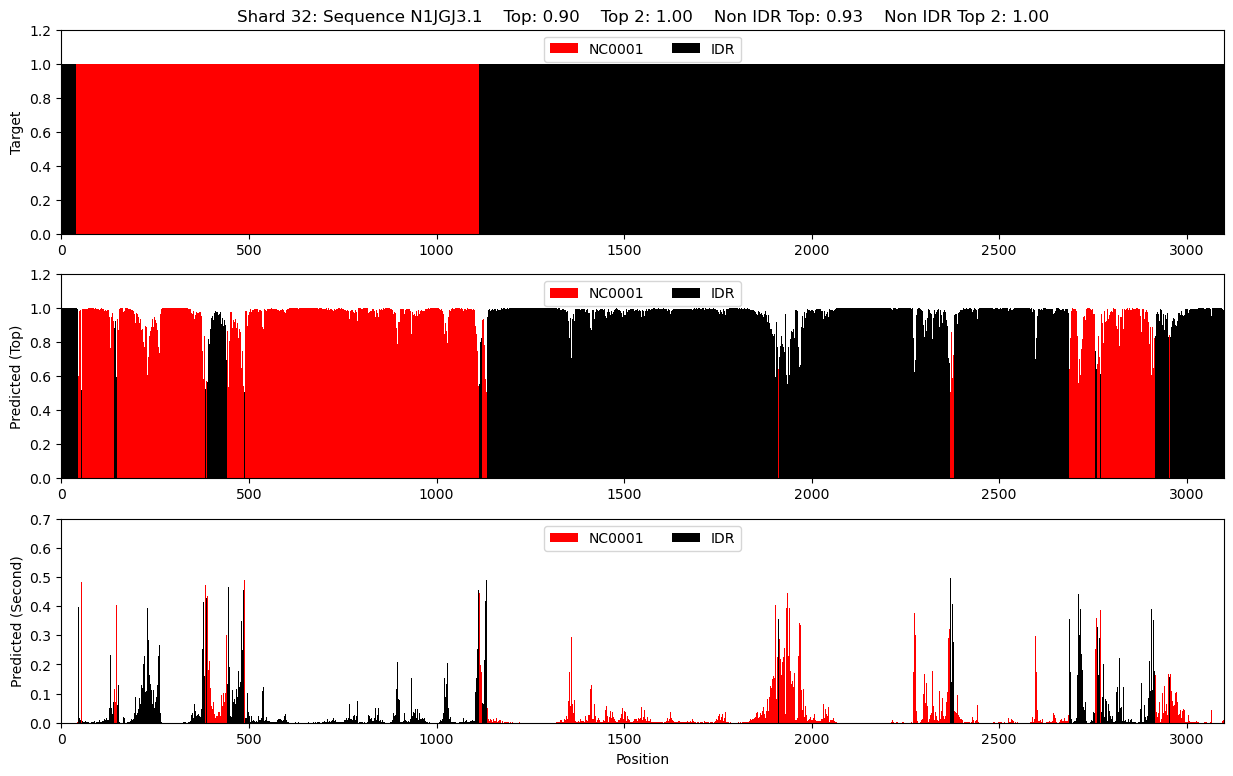

In [77]:
shard = np.random.randint(1,51)
shard = 32
with open(f'../data/results/try_lstm_part2/predictions_esm2_t33_650M_UR50D/shard_{shard}.pkl', 'rb') as g:
        results = pickle.load(g)

with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
clan_map = list(maps['clan_idx'].keys())

keys = list(results.keys())
seq = keys[np.random.randint(0,len(keys))]
seq = 'N1JGJ3.1'

print(f'Shard {shard}: Sequence {seq}')
vz.viewSingleClan(shard, seq, results, clan_map)

In [ ]:
Shard 12: Sequence B0W570.1

In [ ]:
import sys
# sys.path.insert(0, '../py_scripts')
import visualizations as vz
import pickle

with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
fam_map = list(maps['fam_idx'].keys())

In [ ]:
with open(f'../data/results/simple_resume_no_L1/single_pred.pkl', 'rb') as g:
        results = pickle.load(g)

seq = results['label']
shard = results['shard']

print(f'Shard {shard}: Sequence {seq}')
vz.viewSingleFam(shard, seq, results, fam_map)

In [ ]:
import hmmscan_utils as hu

scan_dict = hu.parse_hmmscan_results('../data/split_34_test_ids_full.fasta_scan.txt')

In [ ]:
scan_dict['I0AHU5.1']

In [ ]:
import torch

In [ ]:
test = torch.randn((4,4))

In [ ]:
test

In [ ]:
test[[1,3],[0,2]]

In [ ]:

# Specify the indices for dimension 0 and dimension 1
indices_dim0 = torch.tensor([1, 3])
indices_dim1 = torch.tensor([0, 2])

# Use advanced indexing to get the desired elements
result = test[indices_dim0.reshape(-1, 1), indices_dim1]

print(result)

In [ ]:
# Specify the indices for dimension 0 and dimension 1
indices_dim0 = torch.tensor([1, 3])
indices_dim1 = [0,2]

# Use advanced indexing to get the desired elements
test[indices_dim0[:,None], indices_dim1] = 10

print(test)

In [ ]:
test2 = torch.tensor([1,2,3,4,1,2,1,2,1])

In [ ]:
mask = (test2 == 1)

In [ ]:
mask

In [ ]:
test2 = torch.tensor([1,2,3,4,5,2])

In [ ]:
test3 = torch.where(test2==2)

In [2]:
import sys
import numpy as np
sys.path.insert(0, '../library')
# sys.path.insert(0, '../py_scripts')
import hmmscan_utils as hu
import classifiers as cf
import ml_utils as mu
import visualizations as vz
import torch
import pickle
from pathlib import Path
print("imported")
with open(f'../data/maps.pkl', 'rb') as g:
        maps = pickle.load(g)
fam_map = list(maps['fam_idx'].keys())

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(device)

length_limit = 4096 # Covers 99.75% sequences
model_name =  'esm2_t33_650M_UR50D' #'esm2_t36_3B_UR50D'
num_shards = 50 ###### Replace with appropriate number ###################################
data_utils = mu.DataUtils('../data', num_shards, model_name, length_limit, 'train', device)
print("ESM2 loaded")
classifier = cf.FamModelSimple(data_utils.embedding_dim, data_utils.maps, device).to(device)
classifier_path = Path('../data/results/no_l1_part3/epoch_2.pth')
classifier.load_state_dict(torch.load(classifier_path))
print("Classifier loaded")
classifier.eval()

imported
ESM2 loaded
Classifier loaded


FamModelSimple(
  (lstm): LSTM(1280, 1280, bidirectional=True)
  (linear_stack): Sequential(
    (0): Linear(in_features=2560, out_features=5120, bias=True)
    (1): ReLU()
    (2): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
    (3): Linear(in_features=5120, out_features=5120, bias=True)
    (4): ReLU()
    (5): LayerNorm((5120,), eps=1e-05, elementwise_affine=True)
    (6): Linear(in_features=5120, out_features=19633, bias=True)
  )
)

Shard 40: Sequence Q1GH96.1


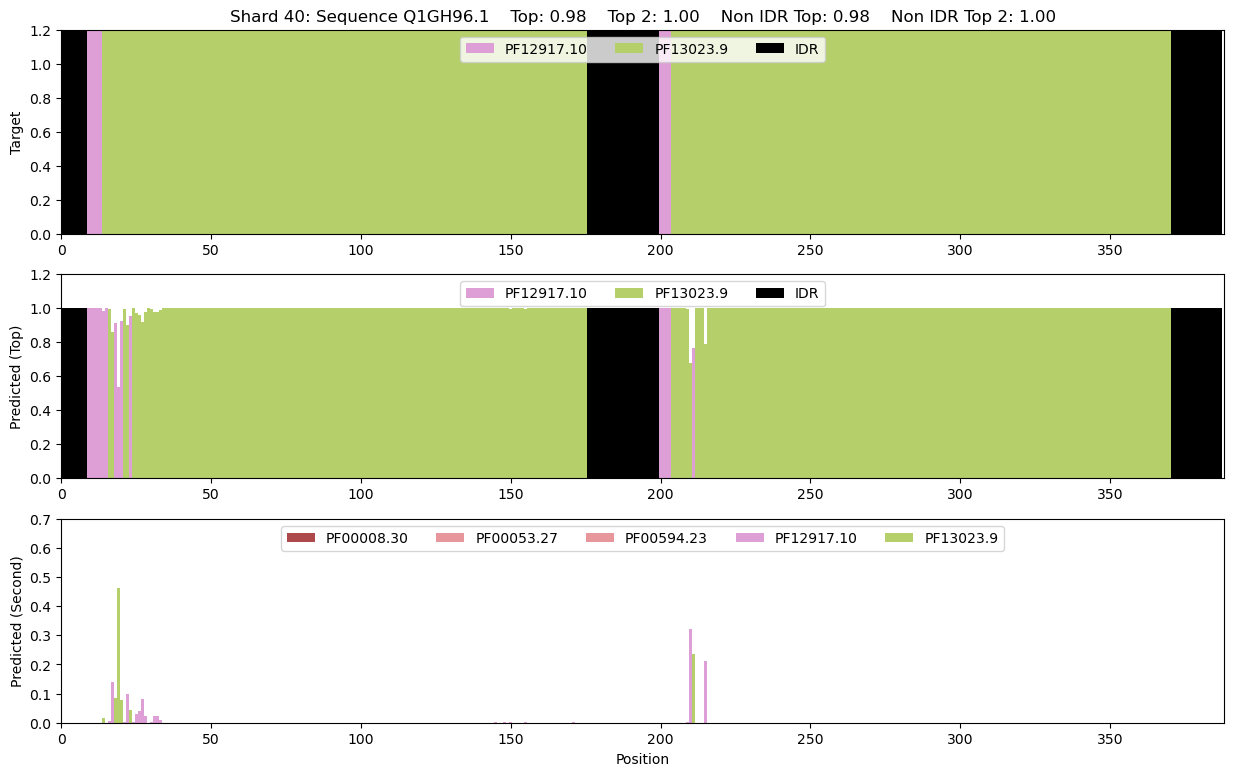

In [5]:
with torch.inference_mode():

    shard = np.random.randint(1,51)
    # shard = 31

    hmm_dict = data_utils.parse_shard(shard)
    keys = list(hmm_dict.keys())
    key_idx = np.random.randint(0,len(keys))
    seq_id = keys[key_idx]
    # seq_id = 'M1DIH1.1'

    dataset = data_utils.get_dataset(shard)
    dataset = data_utils.filter_batches(dataset, [seq_id])
    data_loader = data_utils.get_dataloader(dataset)

    label, seq, token = next(iter(data_loader))
    token = token.to(device)
    embedding = data_utils.get_embedding(token)
    fam_vector, clan_vector = hu.generate_domain_position_list2(hmm_dict, seq_id, data_utils.maps)
                    
    stop_index = min(len(seq[0]), data_utils.length_limit)
    fam_vector = torch.tensor(fam_vector[:stop_index,:]).to(device) # clip the clan_vector to the truncated sequence length
    clan_vector = torch.tensor(clan_vector[:stop_index,:]).to(device)

    weighted_preds, _ = classifier(embedding["representations"][data_utils.last_layer][0,1:stop_index+1,:], clan_vector)
    clan_fam_matrix = maps['clan_family_matrix'].to(device)
    clan_fam_weights = torch.matmul(clan_vector,clan_fam_matrix)

    for i in range(clan_fam_weights.shape[0]): #shape is Lxf
        indices = torch.nonzero(clan_fam_weights[i]).squeeze() #indices for the softmax
        weighted_preds[i,indices] = torch.softmax(weighted_preds[i,indices],dim=0)
 
    results = {}
    results[seq_id] = {}
    top_two_vals, top_two_indices = torch.topk(weighted_preds, k=2, dim=1)

    
    results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
    results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
    results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
    results[seq_id]['fam_true_vals'] = fam_vector.max(dim=1)[1].cpu().numpy()
    results['label'] = seq_id
    results['shard'] = shard
    print(f'Shard {shard}: Sequence {seq_id}')
    vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()))

In [ ]:
hmm_dict['A6GJW3.1']

In [ ]:
print(weighted_preds.shape,weighted_preds.sum(dim=1))

In [ ]:
print(raw_preds.shape,raw_preds.sum(dim=1))

In [ ]:
clan_fam_matrix = maps['clan_family_matrix'].to(device)
clan_fam_weights = torch.matmul(clan_vector,clan_fam_matrix)

In [ ]:
# For each row, print the indices where there are 1s
weighted_preds_clone = weighted_preds.clone()
for i in range(clan_fam_weights.shape[0]): #shape is Lxf
    indices = torch.nonzero(clan_fam_weights[i]).squeeze() #indices for the softmax
    weighted_preds_clone[i,indices] = torch.softmax(weighted_preds[i,indices],dim=0)
    # if i==88:
        # print(f"Row {i}: {indices.tolist()}")

In [ ]:
weighted_preds[1,2892]

In [ ]:
clan_fam_weights.sum(dim=1)

In [ ]:
weighted_preds.sum(dim=1)

In [ ]:
weighted_preds = torch.softmax(weighted_preds,dim=1)

In [ ]:
weighted_preds[0,:]

In [ ]:
weighted_preds

In [ ]:
maps['clan_idx'][maps['fam_clan'][maps['idx_fam'][2892]]]

In [ ]:
viz = top5_argmaxes_with_values(weighted_preds, maps['idx_fam'],2)

In [ ]:
raw_preds_sm = torch.softmax(raw_preds,dim=1)

In [ ]:
results = {}
seq_id = "P14528.1"
shard = 1
results[seq_id] = {}

top_two_vals, top_two_indices = torch.topk(weighted_preds_clone, k=2, dim=1)

results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
results['label'] = seq_id
results['shard'] = shard

In [ ]:
import sys
sys.path.insert(0,"../py_scripts")

import visualizations as vz
print(f'Shard {shard}: Sequence {seq_id}')
vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()))

In [ ]:
results = {}
seq_id = "P14528.1"
shard = 1
results[seq_id] = {}

top_two_vals, top_two_indices = torch.topk(raw_preds_sm, k=2, dim=1)

results[seq_id]['fam_vals'] = top_two_vals.cpu().numpy()
results[seq_id]['fam_idx'] = top_two_indices.cpu().numpy()
results[seq_id]['fam_true'] = torch.argmax(fam_vector, dim=1).cpu().numpy()
results['label'] = seq_id
results['shard'] = shard
print(f'Shard {shard}: Sequence {seq_id}')
vz.viewSingleFam(shard, seq_id, results, list(maps['fam_idx'].keys()))